### Introduction

I am testing the idea of using the juyter notebook as my script so the comments are verbose. Hopefully this helps synchronize the notebook content with the video. Comments on this approach are welcome.

Today, I will take you through the steps to control and download data from your Rigol DS1054Z oscilloscope using Python in a Jupyter notebook. This tutorial uses the DS1054Z library written by Philipp Klaus. This library is required to replicate these examples in your environment.

### Setup the notebook and import the libraries

We need to begin by importing libraries to connect to the oscilloscope and display the data. We also include Python’s matplotlib to plot the data in the notebook.

In [1]:
from ds1054z import DS1054Z
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

These libraries are needed to display the oscilloscope bitmap images.

In [2]:
from IPython.display import Image, display

Finally, include the libraries needed for the single-sided spectral analysis.

In [3]:
from scipy.fft import rfft, rfftfreq

### Connecting and verifying setup

Next, we need to connect to the scope and verify that it responds to basic commands.

In [4]:
scope = DS1054Z('192.168.1.206')
print(scope.idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3


The scope should respond with the make, model, and serial number. It looks like it has, so we have a good connection. 

Ensure the scope is in the run mode to collect some data.

In [5]:
scope.run()

### Downloading a waveform (source screen)

Before downloading the waveform itself, I like to stop the scope to be sure I captured the waveform I intended.

In [6]:
scope.stop()

Take a screenshot of the data from the scope. A bitmap showing the oscilloscope configuration can be a helpful reference to check some of the calculations below.

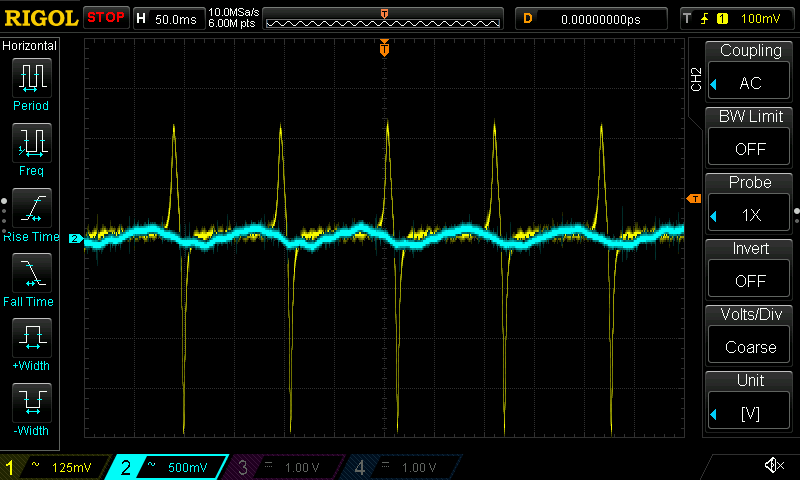

In [7]:
bmap_scope = scope.display_data
display(Image(bmap_scope))

Begin preparing for data collection by saving off the vertical scale characteristics.

In [8]:
Begin preparing for data collection by saving off the vertical scale characteristics.d_voltage_scale = scope.get_channel_scale(1)
d_voltage_scale

0.125

Next, store the timescale value.

In [9]:
d_timebase_scale_actual = float(scope.query(':TIMebase:SCAle?'))
d_timebase_scale_actual

0.05

This command returns a value of 0.050 seconds (50 milliseconds) per division, matching the screenshots above. The scope has twelve horizontal divisions, so the total time for the sample is 50 ms * 12 = 600 ms. In this first example, we will download the screen samples. The oscilloscope will always return 1200 samples.

Knowing the number of samples and the total length of time, the sampling frequency can be estimated as 1200/600 ms = 2000 hertz.

In [10]:
d_fs = 1200/(12.0 * d_timebase_scale_actual)
d_fs

1999.9999999999998

One note of caution: I do not know if the data is anti-aliased before downsampling for the screen. I believe the RAW waveform should be collected to avoid aliasing problems, as described below.

Lastly, I like to store the instrument identification and the signal, so I have a description of the device that acquired the signal. I include this descriptive identifier on the plots along with the signal itself.

In [11]:
str_idn = scope.idn
str_idn

'RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3'

I use Python to download the waveform now that the sampling parameters are stored away. The mode has been set to ‘NORM’ to capture the screen buffer.

In [12]:
d_ch1 = scope.get_waveform_samples(1, mode='NORM')

Restore the oscilloscope to run mode.

In [13]:
scope.run()

Next, I create a time series vector for the independent axis in the plot.

In [14]:
i_ns = len(d_ch1)
np_d_time = np.linspace(0,(i_ns-1),i_ns)/d_fs

We have everything needed for the plot so let’s set that up.

<function matplotlib.pyplot.show(close=None, block=None)>

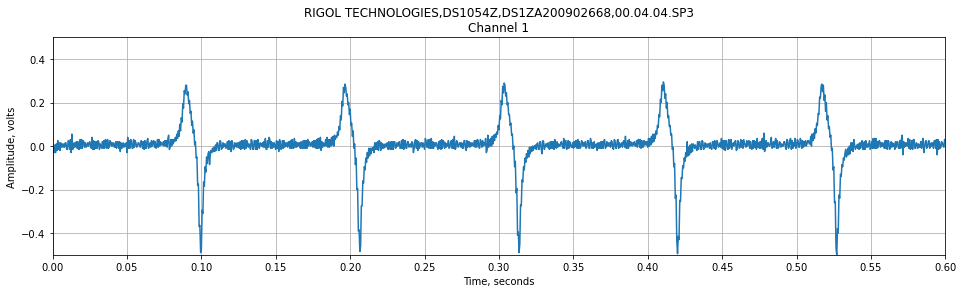

In [15]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.figure
plt.plot(np_d_time, d_ch1)
plt.grid()

plt.xlabel('Time, seconds')
xmax = 12.0*d_timebase_scale_actual
plt.xlim([0, xmax])
plt.xticks(np.linspace(0, xmax, 13))
ax = plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.ylabel('Amplitude, volts')
plt.ylim([-4.0*d_voltage_scale, 4.0 *d_voltage_scale])
plt.title(str_idn + '\n' + 'Channel 1')
plt.show

That looks great and matches the data presented in the screen capture. Next, we will take a spectrum of this data to examine the frequency content.

#### Spectral Analysis (source: screen)

A separate video covers the single-sided spectral analysis in Python. I will post a link to that video. 
These commands calculate the single-sided spectrum and labels for the frequency axis.

In [16]:
cx_y = rfft(d_ch1)/float(i_ns/2.)
d_ws = rfftfreq(i_ns,1./d_fs)

Create the plot and display the single-sided spectrum.

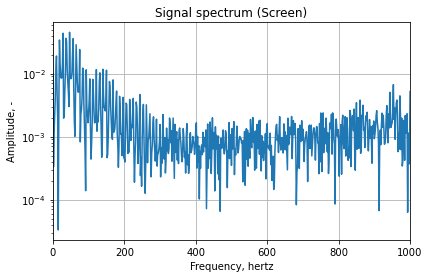

In [41]:
plt.figure()
plt.semilogy(d_ws, abs(cx_y))
plt.grid()
plt.xlabel('Frequency, hertz')
plt.xlim([0, 1000])
plt.ylabel('Amplitude, -')
plt.title('Signal spectrum (Screen)')

figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('Spectrum_Screen.pdf')

### Download a waveform (RAW)

The previous example downloaded just the samples on the screen. This example takes it further and downloads the data stored in memory. The overall workflow will be similar, but some details are different.

As before, stop triggering to ensure the scope captured the data of interest.

In [24]:
scope.stop()

Begin by getting the information needed to make sense of the signals.

In [25]:
d_voltage_scale_raw = scope.get_channel_scale(1)
d_voltage_scale_raw

0.125

The sampling frequency can be downloaded directly from the oscilloscope for this example.

In [26]:
d_fs_raw = float(scope.query(":ACQuire:SRATe?"))
d_fs_raw

10000000.0

A single Python command pulls the number of samples from the instrument.

In [27]:
i_ns_raw = scope.memory_depth_internal_currently_shown
i_ns_raw

6000000

In keeping with good practices, I will pull the instrument identification again

In [28]:
str_idn_raw = scope.idn
str_idn_raw

'RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3'

Next, I enter the Python command to download data from the oscilloscope. Downloading the signal takes a lot of time, on the order of minutes for my arrangement.

In [29]:
d_ch1_raw = scope.get_waveform_samples(1, mode='RAW')

Lastly, I set up the time series for this raw waveform.

In [30]:
np_d_time_raw = np.linspace(0,(i_ns_raw-1), i_ns_raw)/d_fs_raw

Restart the oscilloscope.

In [31]:
scope.run()

Now I can plot this channel signal data.

<function matplotlib.pyplot.show(close=None, block=None)>

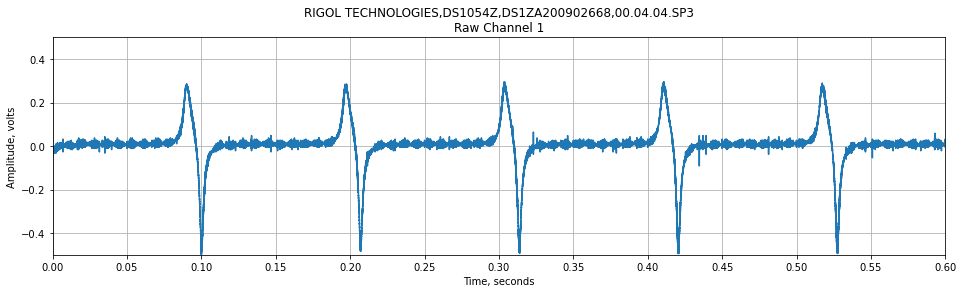

In [32]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.figure
plt.plot(np_d_time_raw, d_ch1_raw)
plt.grid()

plt.xlabel('Time, seconds')
xmax = float(i_ns_raw)/d_fs_raw
plt.xlim([0, xmax])
plt.xticks(np.linspace(0, xmax, 13))
ax = plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.2f'))

plt.ylabel('Amplitude, volts')
plt.ylim([-4.0*d_voltage_scale_raw, 4.0 *d_voltage_scale_raw])
plt.title(str_idn_raw + '\n' + 'Raw Channel 1')

plt.show

#### Spectral Analysis (source: RAW)

These commands calculate the single-sided spectrum and labels for the frequency axis for the raw data.

In [35]:
cx_y_raw = rfft(d_ch1_raw)/float(i_ns_raw/2.)
d_ws_raw = rfftfreq(i_ns_raw,1./d_fs_raw)

Create the plot and display the single-sided spectrum.

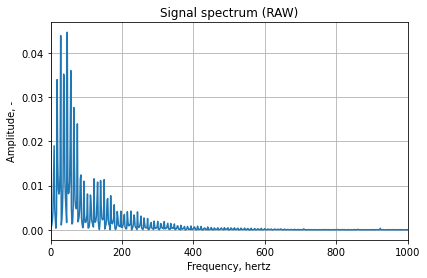

In [44]:
plt.figure()
plt.plot(d_ws_raw, abs(cx_y_raw))
plt.grid()
plt.xlabel('Frequency, hertz')
plt.xlim([0, 1000])
plt.ylabel('Amplitude, -')
plt.title('Signal spectrum (RAW)')

figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('Spectrum_Raw.pdf')